<a href="https://colab.research.google.com/github/luca7891/LU_BAP_CIR/blob/main/Homework%20kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [12]:
#load the dataset from GitHub
url = "https://raw.githubusercontent.com/babakrezaee/MethodsCourses/master/LeidenUniv_MAQM2020/Datasets/R%26P_RezaeeAsadzadeh_MethodsCourse.csv"
dta = pd.read_csv(url)
print(dta.info())

#basic descriptive statistics
num_rows = dta.shape[0]
print(f"Number of rows in dataset: {num_rows}")
summary_stats = dta['Violent_method'].describe()
print(summary_stats)

#first few rows
print(dta.head())

#column names
print(dta.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   startdate                436 non-null    object 
 1   enddate                  436 non-null    object 
 2   finished                 436 non-null    bool   
 3   q1                       436 non-null    object 
 4   DOB                      436 non-null    int64  
 5   Gender                   436 non-null    object 
 6   Marriage                 436 non-null    object 
 7   Ethnicity                436 non-null    object 
 8   Nationality              436 non-null    object 
 9   Religiosity              436 non-null    float64
 10  Education_Col            436 non-null    float64
 11  Education_Grad           435 non-null    float64
 12  Income                   436 non-null    object 
 13  Gandhi                   408 non-null    float64
 14  Mandela                  4

float64


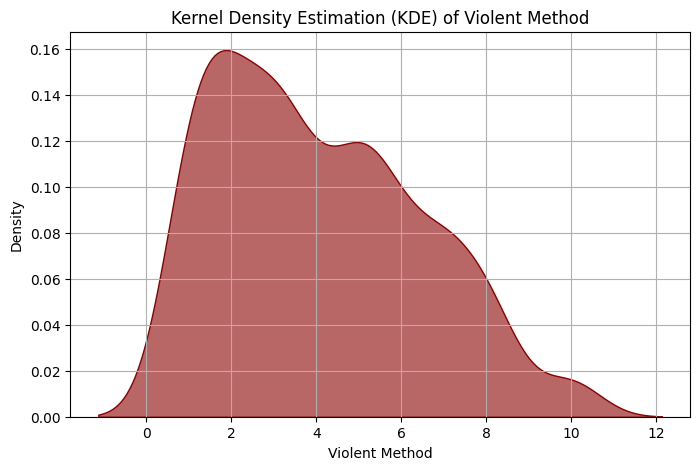

In [9]:
print(dta['Violent_method'].dtype)

plt.figure(figsize=(8,5))
sns.kdeplot(dta['Violent_method'].dropna(), fill=True, color="darkred", alpha=0.6, bw_adjust=1)
plt.title("Kernel Density Estimation (KDE) of Violent Method")
plt.xlabel("Violent Method")
plt.ylabel("Density")
plt.grid(True)
plt.show()


In [14]:
#categorical columns
categorical_columns = ['Gender', 'Marriage', 'Ethnicity', 'Nationality', 'Income', 'Treatment']  # Modify if needed
target_variable = 'Violent_method'

#frequency for categorical columns
for col in categorical_columns:
    print(f"\n Relationship Between '{col}' and '{target_variable}':\n")
    print(pd.crosstab(dta[col], dta[target_variable], normalize='index').round(2))
    print("-" * 80)


 Relationship Between 'Gender' and 'Violent_method':

Violent_method  1.0   1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   \
Gender                                                                       
Female          0.17  0.01   0.0   0.0  0.01  0.01   0.0  0.01  0.04  0.06   
Male            0.12  0.00   0.0   0.0  0.00  0.01   0.0  0.01  0.02  0.02   

Violent_method  ...  7.5   7.6   8.0   8.1   8.2   8.3   8.4   8.5   9.2   \
Gender          ...                                                         
Female          ...  0.02   0.0  0.02  0.01  0.00  0.01  0.01  0.00   0.0   
Male            ...  0.01   0.0  0.02  0.02  0.01  0.00  0.00  0.01   0.0   

Violent_method  10.0  
Gender                
Female          0.01  
Male            0.03  

[2 rows x 67 columns]
--------------------------------------------------------------------------------

 Relationship Between 'Marriage' and 'Violent_method':

Violent_method  1.0   1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   

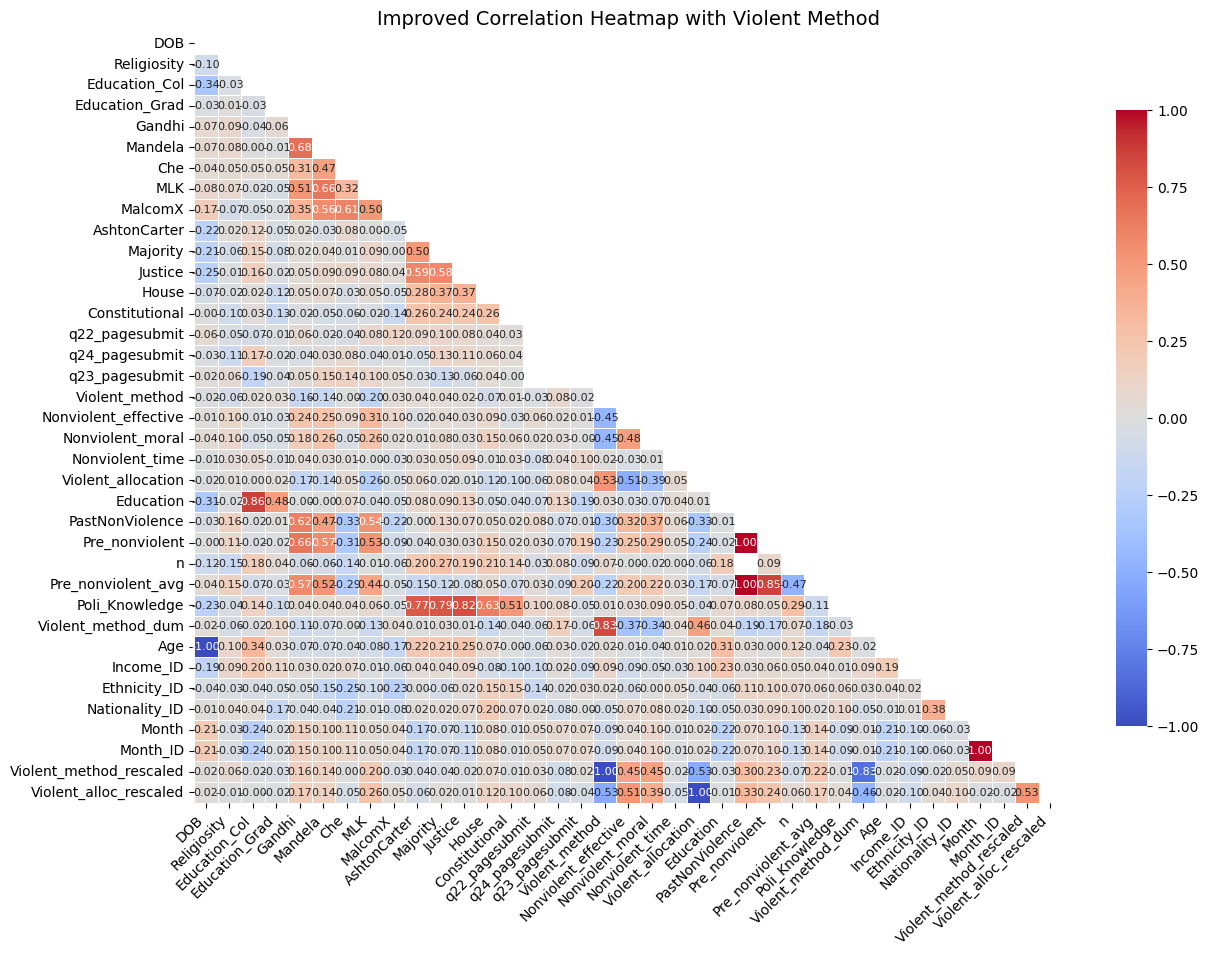

In [16]:
#select only numeric columns
numeric_dta = dta.select_dtypes(include=['number'])

#correlation matrix
correlation_matrix = numeric_dta.corr()

#heatmap with better formatting
#mask to hide the upper triangle (reduces clutter)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

#set up the figure size
plt.figure(figsize=(14, 10))

#plot heatmap with better formatting
sns.heatmap(correlation_matrix,
            mask=mask,  # Hide upper triangle
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            annot_kws={"size": 8},  # Reduce font size
            cbar_kws={"shrink": 0.8})  # Adjust colorbar size

#improve axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-labels for clarity
plt.yticks(fontsize=10)
plt.title("Improved Correlation Heatmap with Violent Method", fontsize=14)

#show plot
plt.show()


In [18]:
correlations = numeric_dta.corr()['Violent_method'].sort_values(ascending=False)
print(correlations.head(10))
#we will keep only "Violoent_allocation" since "Violent_method_dum" is just a binnary dummy and the other var have a weak correlation


Violent_method        1.000000
Violent_method_dum    0.830903
Violent_allocation    0.527237
Income_ID             0.094044
q24_pagesubmit        0.081643
n                     0.070262
Majority              0.038412
AshtonCarter          0.037662
Education             0.033460
Education_Grad        0.031374
Name: Violent_method, dtype: float64


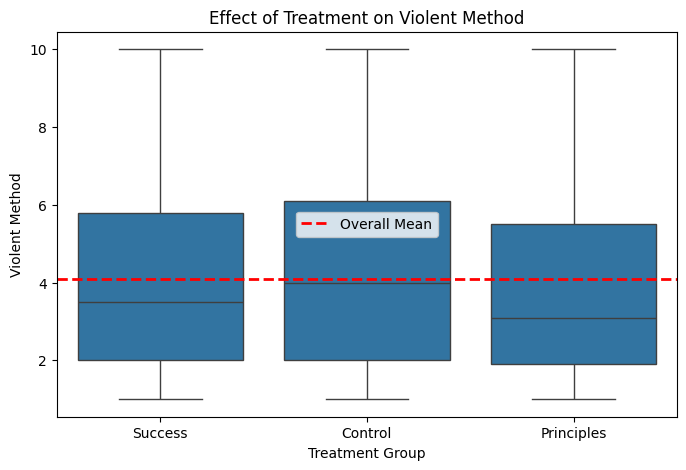

In [20]:
mean_violent_method = dta['Violent_method'].mean()

#plot for "Treatment" effect
plt.figure(figsize=(8,5))
sns.boxplot(x=dta['Treatment'], y=dta['Violent_method'])
plt.axhline(mean_violent_method, color='red', linestyle='dashed', linewidth=2, label="Overall Mean")
plt.title("Effect of Treatment on Violent Method")
plt.xlabel("Treatment Group")
plt.ylabel("Violent Method")
plt.legend()
plt.show()
#from the boxplot we can understand that principles group tends to be less violent -> exposure to non-violent principles reduces justification for violence

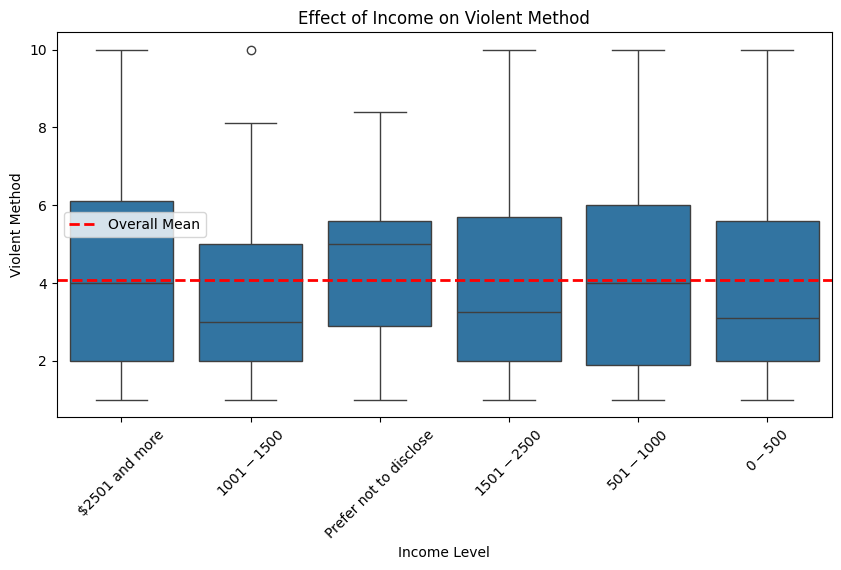

In [23]:
#plot for "Income" effect
plt.figure(figsize=(10,5))
sns.boxplot(x=dta['Income'], y=dta['Violent_method'])
plt.axhline(mean_violent_method, color='red', linestyle='dashed', linewidth=2, label="Overall Mean")
plt.title("Effect of Income on Violent Method")
plt.xlabel("Income Level")
plt.ylabel("Violent Method")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.legend()
plt.show()
#the variance within the medians is really interesting; we can see that low earning and high earning are almost on the mean

In [27]:
#ANOVA test to check if Income groups have different means
anova_result = stats.f_oneway(
    dta[dta['Income'] == '$0-$500']['Violent_method'],
    dta[dta['Income'] == '$501-$1000']['Violent_method'],
    dta[dta['Income'] == '$1001-$1500']['Violent_method'],
    dta[dta['Income'] == '$1501-$2500']['Violent_method'],
    dta[dta['Income'] == '$2501 and more']['Violent_method'],
    dta[dta['Income'] == 'Prefer not to disclose']['Violent_method']
)

print(f"ANOVA p-value: {anova_result.pvalue:.5f}")

# Interpretation
if anova_result.pvalue < 0.05:
    print("Income has a statistically significant effect on Violent_method!")
else:
    print("Income does not have a significant effect.")
#its bugged

ANOVA p-value: nan
Income does not have a significant effect.


In [28]:
#check to see what's the problem(NaN or small groups)
print(dta[['Income', 'Violent_method']].isnull().sum())
print(dta['Income'].value_counts())

Income            0
Violent_method    1
dtype: int64
Income
$0-$500                   126
$2501 and more             87
$501-$1000                 78
$1501-$2500                60
Prefer not to disclose     45
$1001-$1500                40
Name: count, dtype: int64


In [29]:
#new income category
dta['Income_Group'] = dta['Income'].replace({
    '$0-$500': 'Low Income',
    '$501-$1000': 'Low Income',
    '$1001-$1500': 'Middle Income',
    '$1501-$2500': 'Middle Income',
    '$2501 and more': 'High Income',
    'Prefer not to disclose': 'Unknown Income'
})

#new group sizes
print(dta['Income_Group'].value_counts())

Income_Group
Low Income        204
Middle Income     100
High Income        87
Unknown Income     45
Name: count, dtype: int64


In [30]:
#bugged anova
anova_result = stats.f_oneway(
    dta[dta['Income_Group'] == 'Low Income']['Violent_method'],
    dta[dta['Income_Group'] == 'Middle Income']['Violent_method'],
    dta[dta['Income_Group'] == 'High Income']['Violent_method'],
    dta[dta['Income_Group'] == 'Unknown Income']['Violent_method']
)

print(f"ANOVA p-value: {anova_result.pvalue:.5f}")

if anova_result.pvalue < 0.05:
    print("Income has a statistically significant effect on Violent_method!")
else:
    print("Income does not have a significant effect.")

ANOVA p-value: nan
Income does not have a significant effect.


In [33]:
income_variance = dta.groupby('Income_Group')['Violent_method'].var()
print("Variance per Income Group:\n", income_variance)
print(dta[['Income_Group', 'Violent_method']].dtypes)

Variance per Income Group:
 Income_Group
High Income       6.778588
Low Income        5.663982
Middle Income     5.446994
Unknown Income    4.682909
Name: Violent_method, dtype: float64
Income_Group       object
Violent_method    float64
dtype: object


In [36]:
#debug ANOVA
dta['Income_Group'] = dta['Income_Group'].astype('category')
print(dta[['Income_Group', 'Violent_method']].isnull().sum())
dta = dta.dropna(subset=['Income_Group', 'Violent_method'])

Income_Group      0
Violent_method    0
dtype: int64


<ipython-input-36-8ce3a840c170>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dta['Income_Group'] = dta['Income_Group'].astype('category')


In [37]:
anova_result = stats.f_oneway(
    dta[dta['Income_Group'] == 'Low Income']['Violent_method'],
    dta[dta['Income_Group'] == 'Middle Income']['Violent_method'],
    dta[dta['Income_Group'] == 'High Income']['Violent_method'],
    dta[dta['Income_Group'] == 'Unknown Income']['Violent_method']
)

print(f"ANOVA p-value: {anova_result.pvalue:.5f}")

if anova_result.pvalue < 0.05:
    print("Income has a statistically significant effect on Violent_method!")
else:
    print("Income does not have a significant effect.")

ANOVA p-value: 0.32871
❌ Income_Group does not have a significant effect.


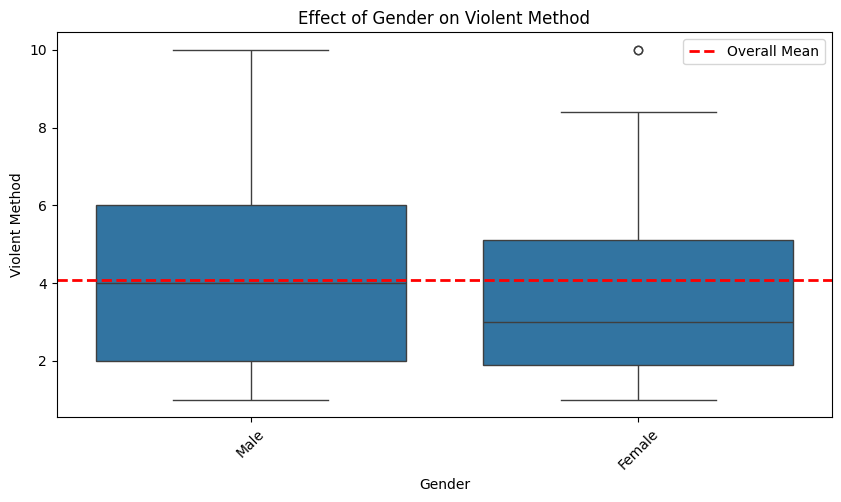

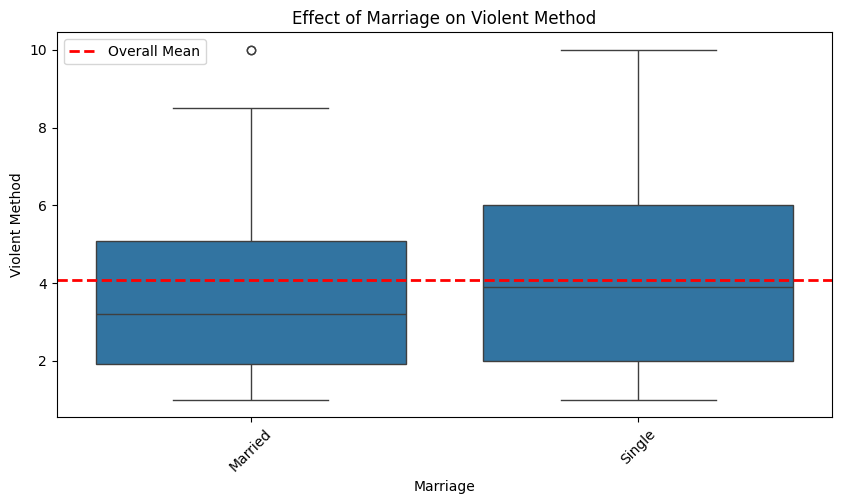

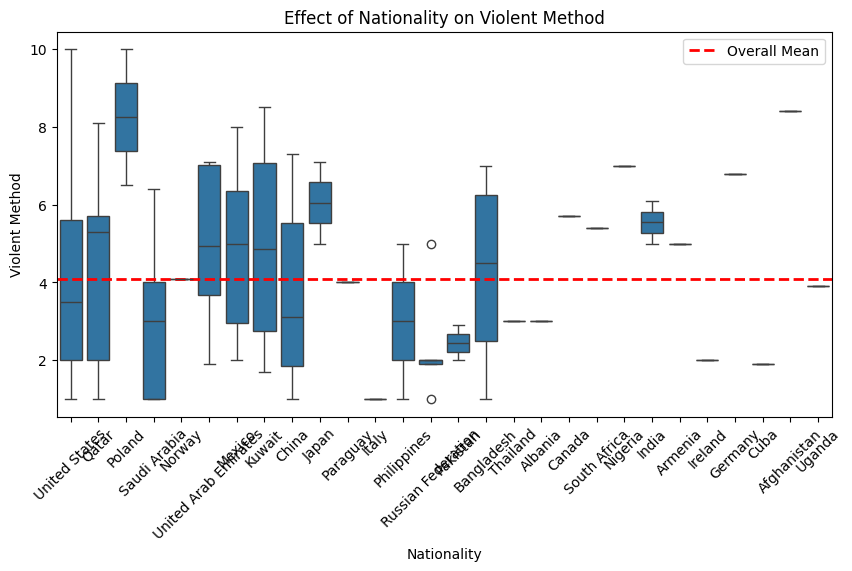

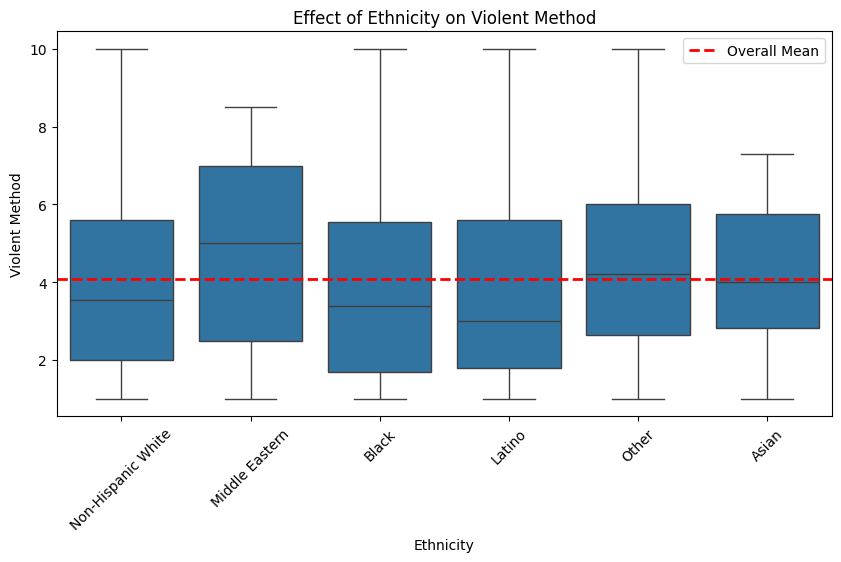

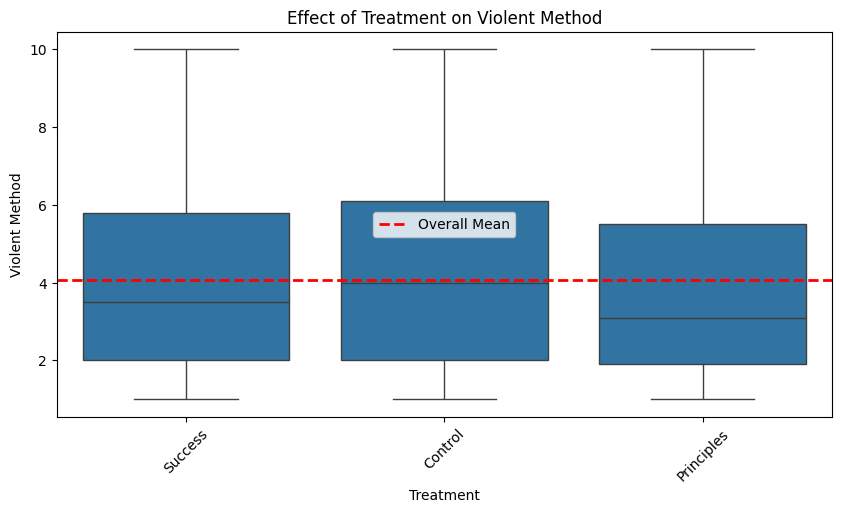

In [40]:
categorical_vars = ['Gender', 'Marriage', 'Nationality', 'Ethnicity', 'Treatment']

for var in categorical_vars:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=dta[var], y=dta['Violent_method'])
    plt.axhline(dta['Violent_method'].mean(), color='red', linestyle='dashed', linewidth=2, label="Overall Mean")
    plt.title(f"Effect of {var} on Violent Method")
    plt.xlabel(var)
    plt.ylabel("Violent Method")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [41]:
#function to run ANOVA for categorical variables
def anova_test(var):
    groups = [dta[dta[var] == cat]['Violent_method'].dropna() for cat in dta[var].unique()]
    anova_result = stats.f_oneway(*groups)

    print(f"ANOVA p-value for {var}: {anova_result.pvalue:.5f}")
    if anova_result.pvalue < 0.05:
        print(f"{var} has a statistically significant effect on Violent_method!")
    else:
        print(f"{var} does not have a significant effect.\n")

# Run ANOVA for each categorical variable
for var in categorical_vars:
    anova_test(var)

ANOVA p-value for Gender: 0.00669
Gender has a statistically significant effect on Violent_method!
ANOVA p-value for Marriage: 0.47895
Marriage does not have a significant effect.

ANOVA p-value for Nationality: 0.50568
Nationality does not have a significant effect.

ANOVA p-value for Ethnicity: 0.62624
Ethnicity does not have a significant effect.

ANOVA p-value for Treatment: 0.30963
Treatment does not have a significant effect.



In [43]:
print(dta[['Education', 'Religiosity', 'Poli_Knowledge', 'Violent_method', 'Income_ID']].corr())

                Education  Religiosity  Poli_Knowledge  Violent_method  \
Education        1.000000    -0.018467        0.071211        0.033460   
Religiosity     -0.018467     1.000000       -0.039867       -0.064528   
Poli_Knowledge   0.071211    -0.039867        1.000000        0.013603   
Violent_method   0.033460    -0.064528        0.013603        1.000000   
Income_ID        0.233969     0.091664        0.010445        0.094044   

                Income_ID  
Education        0.233969  
Religiosity      0.091664  
Poli_Knowledge   0.010445  
Violent_method   0.094044  
Income_ID        1.000000  


After all this test, we can see that the most effect on our target variable(**'Violent_methods'**) are **'Gender'** and **'Violent_allocation'**. Since all the other categoricals are statistically insignificant and the numerical variables have a weak correlation, there is no need for another variable since it might introduce noise and not help with the accuracy of the model. Although we considered the **'Income'** category insignificant, we will choose its numerical encoding(**'Income_ID'**) because it has the second strongest correlation.

In [45]:
#relevant features
features = ["Gender", "Violent_allocation", "Income_ID"]
target = "Violent_method"

In [46]:
print(dta.isnull().sum())

startdate                    0
enddate                      0
finished                     0
q1                           0
DOB                          0
Gender                       0
Marriage                     0
Ethnicity                    0
Nationality                  0
Religiosity                  0
Education_Col                0
Education_Grad               1
Income                       0
Gandhi                      28
Mandela                     31
Che                        184
MLK                          7
MalcomX                     29
AshtonCarter                 0
Majority                     0
Justice                      0
House                        0
Constitutional               0
q22_pagesubmit             290
q24_pagesubmit             290
q23_pagesubmit             290
Violent_method               0
Nonviolent_effective         0
Nonviolent_moral             0
Nonviolent_time              0
Violent_allocation           0
Education                    1
PastNonV

In [47]:
#drop columns with too many missing values
drop_columns = ["Che", "q22_pagesubmit", "q24_pagesubmit", "q23_pagesubmit", "PastNonViolence"]
dta.drop(columns=drop_columns, inplace=True)

#replace missing values with median for selected columns
fill_columns = ["Education_Grad", "Gandhi", "Mandela", "MLK", "MalcomX", "Education", "Pre_nonviolent_avg"]
for col in fill_columns:
    dta[col].fillna(dta[col].median(), inplace=True)

# Verify missing values are handled
print(dta.isnull().sum())  # Should print 0 for all remaining columns


startdate                  0
enddate                    0
finished                   0
q1                         0
DOB                        0
Gender                     0
Marriage                   0
Ethnicity                  0
Nationality                0
Religiosity                0
Education_Col              0
Education_Grad             0
Income                     0
Gandhi                     0
Mandela                    0
MLK                        0
MalcomX                    0
AshtonCarter               0
Majority                   0
Justice                    0
House                      0
Constitutional             0
Violent_method             0
Nonviolent_effective       0
Nonviolent_moral           0
Nonviolent_time            0
Violent_allocation         0
Education                  0
Pre_nonviolent             0
n                          0
Pre_nonviolent_avg         0
Poli_Knowledge             0
Treatment                  0
Violent_method_dum         0
Age           

<ipython-input-47-de493d28b95e>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dta[col].fillna(dta[col].median(), inplace=True)


In [55]:
# Encode 'Gender' (convert Male/Female to 0/1)
label_encoder = LabelEncoder()
dta["Gender"] = label_encoder.fit_transform(dta["Gender"])

# Define feature matrix (X) and target variable (y)
features = ["Gender", "Violent_allocation", "Income_ID"]
X = dta[features].copy()  # Ensure X is a separate copy to avoid warnings
y = dta["Violent_method"]

# Convert 'Income_ID' to float
X["Income_ID"] = X["Income_ID"].astype(float)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[["Violent_allocation", "Income_ID"]])

# Convert back to DataFrame and update X
X_scaled_df = pd.DataFrame(X_scaled, columns=["Violent_allocation", "Income_ID"], index=X.index)
X.update(X_scaled_df)

# Verify
print(X.dtypes)

#split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Gender                  int64
Violent_allocation    float64
Income_ID             float64
dtype: object


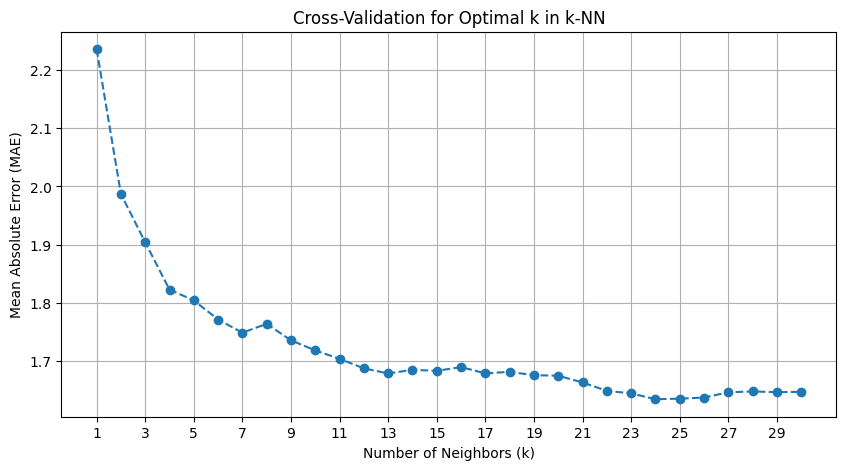

24

In [58]:
#the range of k values to test
k_values = range(1, 31)
cv_scores = []

#cross-validation for different values of k
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=kf, scoring='neg_mean_absolute_error')
    cv_scores.append(-scores.mean())  # Convert negative MAE to positive

#plot the cross-validation results
plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Cross-Validation for Optimal k in k-NN')
plt.xticks(range(1, 31, 2))
plt.grid()
plt.show()

#optimal k with the lowest MAE
optimal_k = k_values[np.argmin(cv_scores)]
optimal_k


We can see that between 21 and 25, the MAE stabilise. To balance bias and variance, we will pick 24 since we have a small 'elbow' as well.

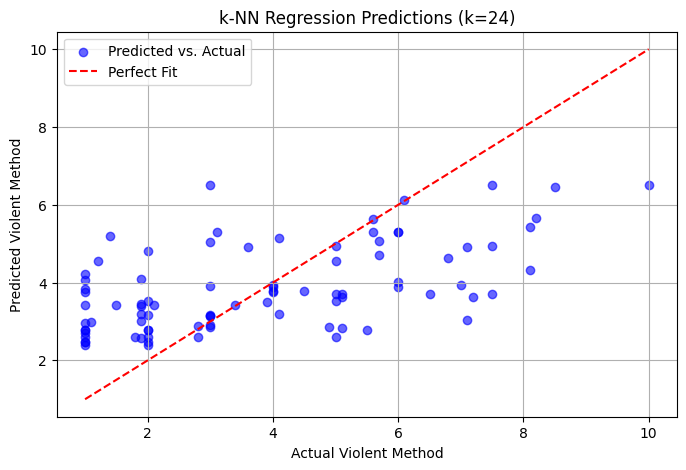

In [60]:
#initialize k-NN regressor with k=24
knn_regressor_final = KNeighborsRegressor(n_neighbors=24)

#train the model on the training data
knn_regressor_final.fit(X_train, y_train)

#make predictions on the test set
y_pred = knn_regressor_final.predict(X_test)

#evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

#results
mae, mse, rmse, r2

#scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color="blue", alpha=0.6, label="Predicted vs. Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit")
plt.xlabel("Actual Violent Method")
plt.ylabel("Predicted Violent Method")
plt.title("k-NN Regression Predictions (k=24)")
plt.legend()
plt.grid(True)
plt.show()

We have low MAE and RMSE, which is a good sign, meaning that predictions are close to the real value. Altought, our model can only explain 32%, which is inssuficent.